In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import random
import re
import numpy as np
import seaborn as sns
from collections import defaultdict,Counter
from sklearn.model_selection import train_test_split

In [2]:
# Đường dẫn đến file rockyou.txt
file_path = 'rockyou.txt'

# 1. Kiểm tra kích thước file
file_size = os.path.getsize(file_path)
print(f'Kích thước file: {file_size / (1024 * 1024):.2f} MB')

Kích thước file: 635.11 MB


In [3]:
# 2. Đọc dữ liệu từng dòng vào pandas
with open(file_path, 'r', encoding='latin-1', errors='ignore') as f:
    lines = [line.strip() for line in f if line.strip()]

# Chuyển thành DataFrame
df = pd.DataFrame([line.strip() for line in lines], columns=['password'])

# 3. Hiển thị 5 dòng đầu tiên
print('\n5 dòng đầu tiên trong file:')
df.head()


5 dòng đầu tiên trong file:


,password
0,onyx22
1,browncar2
2,naigi66666
3,henslee
4,shiasakura32


In [4]:
# 3. Chia tập 80% huấn luyện, 20% kiểm tra
with open('rockyou_train.txt', 'r', encoding='latin-1', errors='ignore') as f:
    train_data = [line.strip() for line in f if line.strip()]
with open('rockyou_test.txt', 'r', encoding='latin-1', errors='ignore') as f:
    test_data = [line.strip() for line in f if line.strip()]

# 4. Chuyển sang DataFrame để in head(5)
train_df = pd.DataFrame(train_data, columns=['password'])
test_df = pd.DataFrame(test_data, columns=['password'])

# 5. In kết quả
print(f'\nTổng số mật khẩu: {len(lines)}')
print(f'Số lượng tập huấn luyện (80%): {len(train_data)}')
print(f'Số lượng tập kiểm tra (20%): {len(test_data)}')


Tổng số mật khẩu: 63378468
Số lượng tập huấn luyện (80%): 50702774
Số lượng tập kiểm tra (20%): 12675693


In [5]:
# 5. Hiển thị 5 dòng đầu của mỗi tập
print('5 dòng đầu trong tập huấn luyện:')
train_df.head()

5 dòng đầu trong tập huấn luyện:


,password
0,425425ozen
1,05035583
2,ws092283
3,shakedia75
4,84313043


In [6]:
print('5 dòng đầu trong tập kiểm thử:')
test_df.head()

5 dòng đầu trong tập kiểm thử:


,password
0,1HptBitB
1,courto30
2,zlwkiss8
3,12Steelers
4,artsew84


In [19]:
# ----------------- Utility --------------------
def char_type(ch):
    if ch.islower() or ch.isupper():
        return 'L'
    elif ch.isdigit():
        return 'N'
    else:
        return 'S'

def password_to_pattern(password):
    if not password:
        return ""
    segments = []
    current_type = char_type(password[0])
    count = 1
    for ch in password[1:]:
        t = char_type(ch)
        if t == current_type:
            count += 1
        else:
            segments.append(f"{current_type}{count}")
            count = 1
            current_type = t
    segments.append(f"{current_type}{count}")
    return ''.join(segments)

def count_segments(password):
    if not password:
        return 0
    count = 1
    current_type = char_type(password[0])
    for ch in password[1:]:
        t = char_type(ch)
        if t != current_type:
            count += 1
            current_type = t
    return count

def space_out_pattern(pat):
    return ' '.join(re.findall(r'[A-Z]\d+', pat))

# ------------------ Step 1 ---------------------
# Đọc tập test
with open("rockyou_test.txt", "r", encoding="latin-1", errors="ignore") as f:
    test_data = [line.strip() for line in f if line.strip()]

# Phân loại theo segment và pattern
seg_pattern_dict = defaultdict(list)
for pw in test_data:
    s = count_segments(pw)
    pat = password_to_pattern(pw)
    if 1 <= s <= 12:
        seg_pattern_dict[s].append(pat)

# Chọn top 21 pattern phổ biến nhất theo từng segment
top21_patterns = {}
for s in range(1, 13):
    counter = Counter(seg_pattern_dict[s])
    top21 = set(counter.most_common(21))
    top21_patterns[s] = set(p[0] for p in top21)

# Lọc tập test theo pattern phổ biến
filtered_test_by_segment = defaultdict(list)
for pw in test_data:
    s = count_segments(pw)
    pat = password_to_pattern(pw)
    if pat in top21_patterns[s]:
        filtered_test_by_segment[s].append(pw)

# ------------------ Step 2 ---------------------
def compute_segment_HR(segment_file, filtered_test_pwds):
    with open(segment_file, "r", encoding="latin-1", errors="ignore") as f:
        generated_passwords = set(line.strip() for line in f if line.strip())

    nh = 0
    tc = len(filtered_test_pwds)
    for pwd in filtered_test_pwds:
        if pwd in generated_passwords:
            nh += 1
    return (nh / tc) * 100 if tc > 0 else 0.0

# ------------------ Step 3 ---------------------
models = {
    "PassGPT": "Generate_passgpt/Segment_{}.txt",
    "VQ-PassGPT": "Generate_passgptv2/Segment_{}.txt"
}

results = defaultdict(dict)

for model_name, path_template in models.items():
    for s in range(1, 13):
        test_pwds = filtered_test_by_segment[s]
        gen_file = path_template.format(s)
        hr = compute_segment_HR(gen_file, test_pwds)
        results[model_name][s] = hr

# ------------------ Step 4 ---------------------
# In kết quả
print("Tỷ lệ đoán đúng theo từng segment:")
print(f"{'Segment':<8}{'PassGPT':>10}{'VQ-PassGPT':>12}")
for s in range(1, 13):
    gpt = results['PassGPT'][s]
    gptv2 = results['VQ-PassGPT'][s]
    print(f"{s:<8}{gpt:10.2f}%{gptv2:12.2f}%")


Tỷ lệ đoán đúng theo từng segment:
Segment    PassGPT  VQ-PassGPT
1             0.82%        0.86%
2             0.85%        1.01%
3             2.89%        3.01%
4             4.12%        5.59%
5             6.74%       11.66%
6             5.35%        8.90%
7             4.08%        8.64%
8             4.25%        5.90%
9             1.41%        3.61%
10            3.07%        9.59%
11            1.23%        7.82%
12            2.43%        6.49%


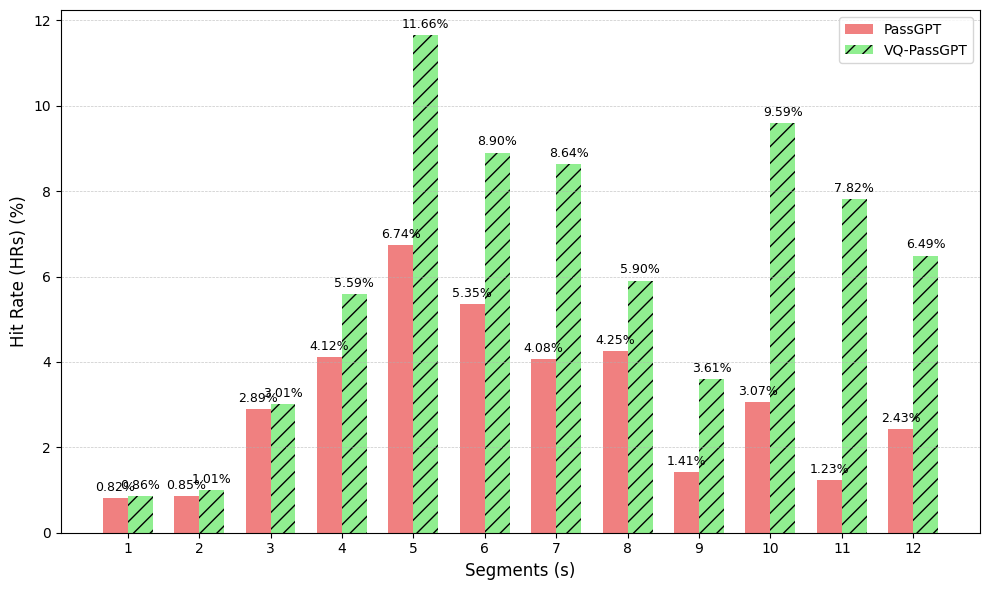

In [8]:
# List of segments from 1 to 12
s_values = list(range(1, 13))

# Retrieve HRs from previously calculated results
passgpt_values = [results['PassGPT'][s] for s in s_values]
passgptv2_values = [results['VQ-PassGPT'][s] for s in s_values]

# X-axis positions
x = np.arange(len(s_values))
width = 0.35  # width of each bar

# Create the bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, passgpt_values, width, label='PassGPT', color='lightcoral')
bars2 = ax.bar(x + width/2, passgptv2_values, width, label='VQ-PassGPT', color='lightgreen', hatch='//')

# Axis labels and title
ax.set_xlabel('Segments (s)', fontsize=12)
ax.set_ylabel('Hit Rate (HRs) (%)', fontsize=12)
#ax.set_title('So sánh HRs với từng Segment giữa PassGPT và VQ-PassGPT', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(s_values)
ax.legend()

# Add value annotations above bars
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # offset upwards
                textcoords="offset points",
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()


In [9]:
# 1. Character type categorization
def char_type(ch):
    if ch.islower():
        return 'L'
    elif ch.isupper():
        return 'U'
    elif ch.isdigit():
        return 'N'
    else:
        return 'S'

# 2. Convert password into pattern string
def extract_pattern(password):
    if not password:
        return ""
    pattern = []
    current_type = char_type(password[0])
    length = 1
    for ch in password[1:]:
        t = char_type(ch)
        if t == current_type:
            length += 1
        else:
            pattern.append(f"{current_type}{length}")
            current_type = t
            length = 1
    pattern.append(f"{current_type}{length}")
    return ' '.join(pattern)  # Insert space for easier tokenization

# 3. Group passwords by segment count and pattern
def group_by_pattern(test_set):
    pattern_groups = defaultdict(list)
    pattern_counter = defaultdict(Counter)
    for pwd in test_set:
        pattern = extract_pattern(pwd)
        s = len(pattern.split())  # count segments
        pattern_groups[s].append((pattern, pwd))
        pattern_counter[s][pattern] += 1
    return pattern_groups, pattern_counter

# 4. Compute HRP by segment and top-5 patterns
def compute_HRPs(generated_file, test_set):
    with open(generated_file, 'r', encoding='latin-1', errors='ignore') as f:
        generated_passwords = set(line.strip() for line in f if line.strip())

    pattern_groups, pattern_counter = group_by_pattern(test_set)

    HRP_result = defaultdict(dict)
    for s in range(1, 7):  # segment count from 1 to 6
        top5_patterns = [p for p, _ in pattern_counter[s].most_common(5)]
        for pattern in top5_patterns:
            passwords_in_P = [pwd for pat, pwd in pattern_groups[s] if pat == pattern]
            total_P = len(passwords_in_P)
            hit_P = sum(1 for pwd in passwords_in_P if pwd in generated_passwords)
            HRP_result[s][pattern] = (hit_P / total_P) * 100 if total_P > 0 else 0.0
    return HRP_result

In [10]:
def merge_segment_files(base_dir, output_file, max_segment=6):
    with open(output_file, 'w', encoding='utf-8') as outfile:
        for s in range(1, max_segment + 1):
            segment_file = os.path.join(base_dir, f"Segment_{s}.txt")
            if os.path.exists(segment_file):
                with open(segment_file, 'r', encoding='utf-8', errors='ignore') as infile:
                    for line in infile:
                        if line.strip():
                            outfile.write(line)
            else:
                print(f"Warning: {segment_file} not found!")

# Sử dụng cho PassGPT và PassGPTv2
merge_segment_files("Generate_passgpt", "Generate_passgpt/Segment_1_to_6.txt")
merge_segment_files("Generate_passgptv2", "Generate_passgptv2/Segment_1_to_6.txt")

In [10]:
# Load test set
with open("rockyou_test.txt", "r", encoding="latin-1") as f:
    test_data = [line.strip() for line in f if line.strip()]

# Compute HRPs for each model
hrp_passgpt = compute_HRPs("Generate_passgpt/Segment_1_to_6.txt", test_data)
hrp_passgptv2 = compute_HRPs("Generate_passgptv2/Segment_1_to_6.txt", test_data)

# Display results
for s in range(1, 7):
    print(f"\nSegment {s}")
    print("Pattern\t\t\tPassGPT\t\tVQ-PassGPT")
    for pattern in hrp_passgpt[s]:
        gpt1 = hrp_passgpt[s].get(pattern, 0)
        gpt2 = hrp_passgptv2[s].get(pattern, 0)
        print(f"{pattern:<24} {gpt1:.2f}%\t\t{gpt2:.2f}%")


Segment 1
Pattern			PassGPT		VQ-PassGPT
L8                       0.23%		0.25%
L9                       0.23%		0.25%
L6                       0.83%		0.93%
L7                       0.46%		0.53%
N8                       0.36%		0.43%

Segment 2
Pattern			PassGPT		VQ-PassGPT
L6 N2                    0.44%		0.55%
L4 N4                    0.43%		0.42%
L5 N4                    0.52%		0.53%
L7 N2                    0.67%		0.86%
L6 N4                    0.39%		0.41%

Segment 3
Pattern			PassGPT		VQ-PassGPT
U1 L5 N2                 0.39%		0.52%
U1 L6 N2                 0.51%		0.71%
U1 L3 N4                 0.26%		0.27%
U1 L4 N4                 0.42%		0.42%
U1 L5 N4                 0.32%		0.32%

Segment 4
Pattern			PassGPT		VQ-PassGPT
L2 N2 L2 N2              1.92%		1.69%
L3 N1 L3 N1              5.19%		4.71%
U1 L5 S1 N2              1.68%		1.40%
U1 L4 S1 N2              2.02%		2.15%
U1 L5 N2 S1              3.69%		3.65%

Segment 5
Pattern			PassGPT		VQ-PassGPT
U1 L2 U1 L2 N2           0.03%		0.0

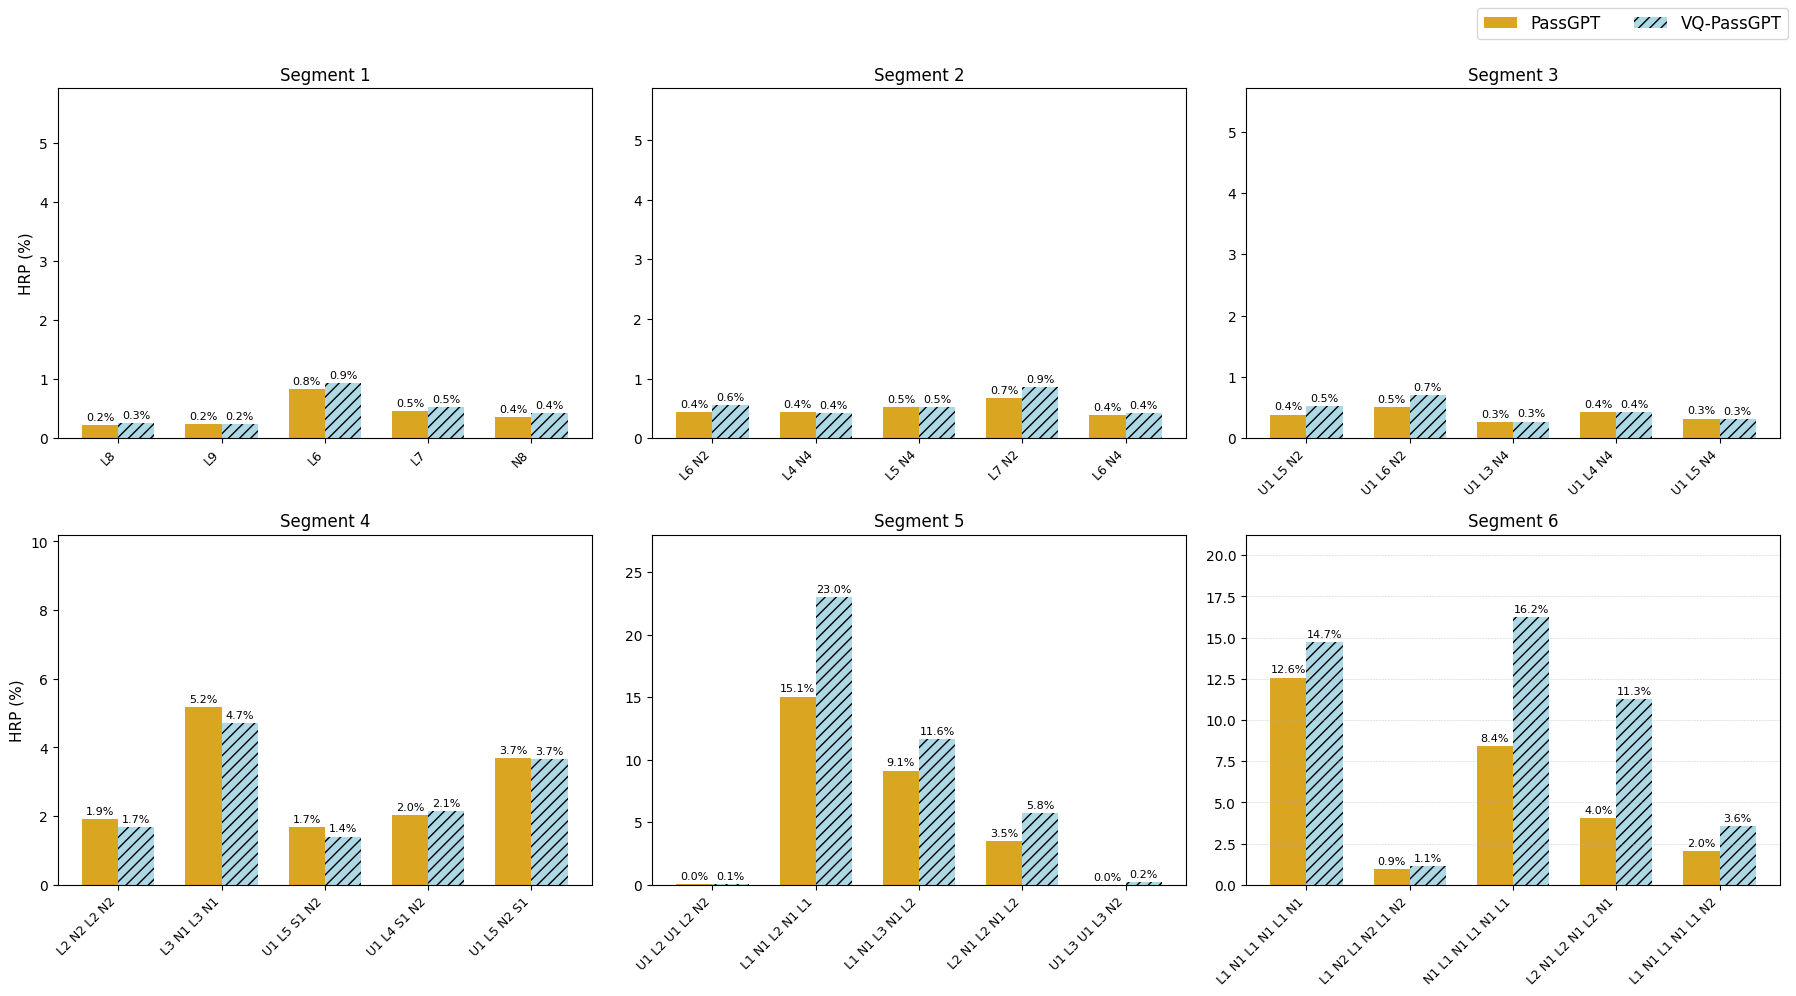

In [11]:
def plot_all_segments_hrp(hrp_passgpt, hrp_passgptv2, max_segment=6):
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))  # 2 hàng, 3 cột
    axs = axs.flatten()  # Chuyển 2D -> 1D list để dễ index
    width = 0.35

    for s in range(1, max_segment + 1):
        ax = axs[s - 1]
        patterns = list(hrp_passgpt[s].keys())
        passgpt_values = [hrp_passgpt[s][p] for p in patterns]
        passgptv2_values = [hrp_passgptv2[s][p] for p in patterns]
        x = np.arange(len(patterns))

        ax.bar(x - width/2, passgpt_values, width, label='PassGPT', color='goldenrod')
        ax.bar(x + width/2, passgptv2_values, width, label='VQ-PassGPT', color='lightblue', hatch='///')

        ax.set_title(f'Segment {s}', fontsize=12)
        ax.set_xticks(x)
        ax.set_xticklabels(patterns, rotation=45, ha='right', fontsize=9)
        ax.set_ylim(0, max(max(passgpt_values, default=0), max(passgptv2_values, default=0)) + 5)

        for bar in ax.containers:
            ax.bar_label(bar, fmt='%.1f%%', padding=2, fontsize=8)

        if s in [1, 4]:
            ax.set_ylabel('HRP (%)', fontsize=11)

    # Add one legend for the entire figure
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', ncol=2, fontsize=12)

    #fig.suptitle('So sánh đánh giá HRP với các mẫu (Segments từ 1 đến 6)', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.grid(axis='y', linestyle='--', linewidth=0.4, alpha=0.6)
    plt.show()

# Gọi hàm (đảm bảo đã có hrp_passgpt và hrp_passgptv2)
plot_all_segments_hrp(hrp_passgpt, hrp_passgptv2)

In [7]:
# Danh sách generator và số lượng
generators = ['pcfg', 'omen', 'passgan','passgpt','passgptv2']
sizes = ['1e5', '1e6', '1e7', '1e8']
# Đảm bảo test_data đã strip trước
test_data = [pw.strip() for pw in test_data]
test_data_set = set(test_data)
# Dictionary lưu accuracy
accuracies = {}

# Tính accuracy
for gen in generators:
    if gen == 'passgptv2':
        accuracies['VQ-PASSGPT'] = {}
    else:
        accuracies[gen.upper()] = {}
    for size in sizes:
        print(f'==> Đang tiến hành với model {gen} với {size} mật khẩu.')
        file_path = f'{gen}_GEN/{gen}_gen_{size}.txt'
        match_count = 0
        with open(file_path, 'r', encoding='latin-1', errors='ignore') as f:
            for line in f:
                if line.strip() in test_data_set:
                    match_count += 1
        accuracy = (match_count / len(test_data)) * 100 if test_data else 0
        if gen == 'passgptv2':
            accuracies['VQ-PASSGPT'][size] = accuracy
        else:
            accuracies[gen.upper()][size] = accuracy

# Tạo DataFrame từ dict
accuracy_df = pd.DataFrame(accuracies).T
accuracy_df = accuracy_df[sizes]

# Hiển thị bảng kết quả
print("\n🔎 Bảng độ chính xác (Accuracy %) trên tập kiểm thử:\n")
accuracy_df.round(4)


==> Đang tiến hành với model pcfg với 1e5 mật khẩu.
==> Đang tiến hành với model pcfg với 1e6 mật khẩu.
==> Đang tiến hành với model pcfg với 1e7 mật khẩu.
==> Đang tiến hành với model pcfg với 1e8 mật khẩu.
==> Đang tiến hành với model omen với 1e5 mật khẩu.
==> Đang tiến hành với model omen với 1e6 mật khẩu.
==> Đang tiến hành với model omen với 1e7 mật khẩu.
==> Đang tiến hành với model omen với 1e8 mật khẩu.
==> Đang tiến hành với model passgan với 1e5 mật khẩu.
==> Đang tiến hành với model passgan với 1e6 mật khẩu.
==> Đang tiến hành với model passgan với 1e7 mật khẩu.
==> Đang tiến hành với model passgan với 1e8 mật khẩu.
==> Đang tiến hành với model passgpt với 1e5 mật khẩu.
==> Đang tiến hành với model passgpt với 1e6 mật khẩu.
==> Đang tiến hành với model passgpt với 1e7 mật khẩu.
==> Đang tiến hành với model passgpt với 1e8 mật khẩu.
==> Đang tiến hành với model passgptv2 với 1e5 mật khẩu.
==> Đang tiến hành với model passgptv2 với 1e6 mật khẩu.
==> Đang tiến hành với model p

,1e5,1e6,1e7,1e8
PCFG,0.2250,1.0884,1.1671,1.1692
OMEN,0.1530,0.7802,3.7755,9.7900
PASSGAN,0.0150,0.1183,0.6710,2.4374
PASSGPT,0.0210,0.2100,2.0152,13.9524
VQ-PASSGPT,0.0284,0.2642,2.4258,16.5671


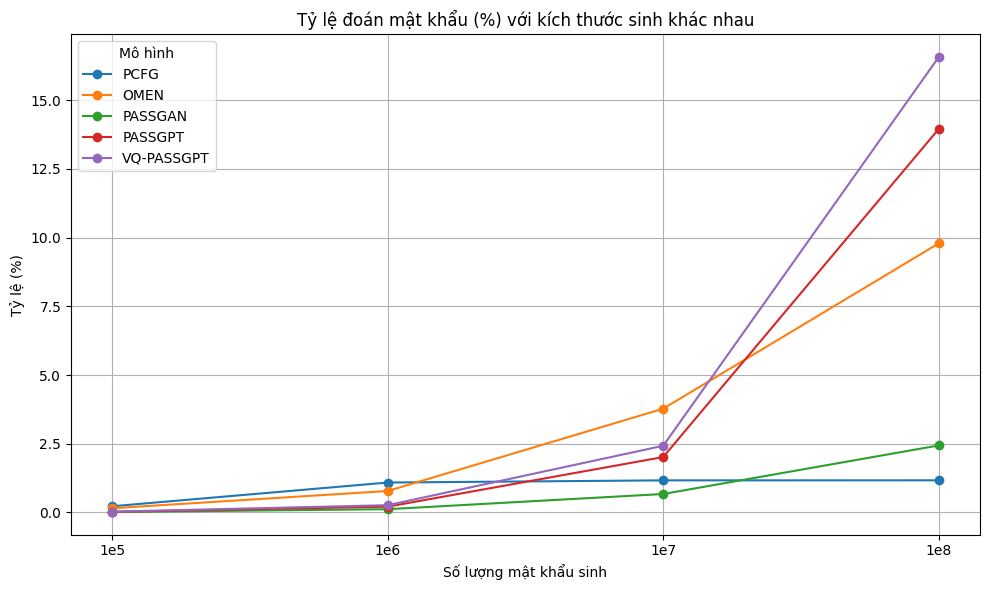

In [8]:
# Đặt kích thước biểu đồ
plt.figure(figsize=(10, 6))

# Vẽ từng dòng (mỗi mô hình)
for model in accuracy_df.index:
    if model == 'passgptv2':
        model = 'VQ-passgpt'
    plt.plot(sizes, accuracy_df.loc[model], marker='o', label=model)

# Add title and labels
plt.title('Tỷ lệ đoán mật khẩu (%) với kích thước sinh khác nhau')
plt.xlabel('Số lượng mật khẩu sinh')
plt.ylabel('Tỷ lệ (%)')
plt.grid(True)
plt.legend(title='Mô hình')
plt.tight_layout()

# Display the plot
plt.show()

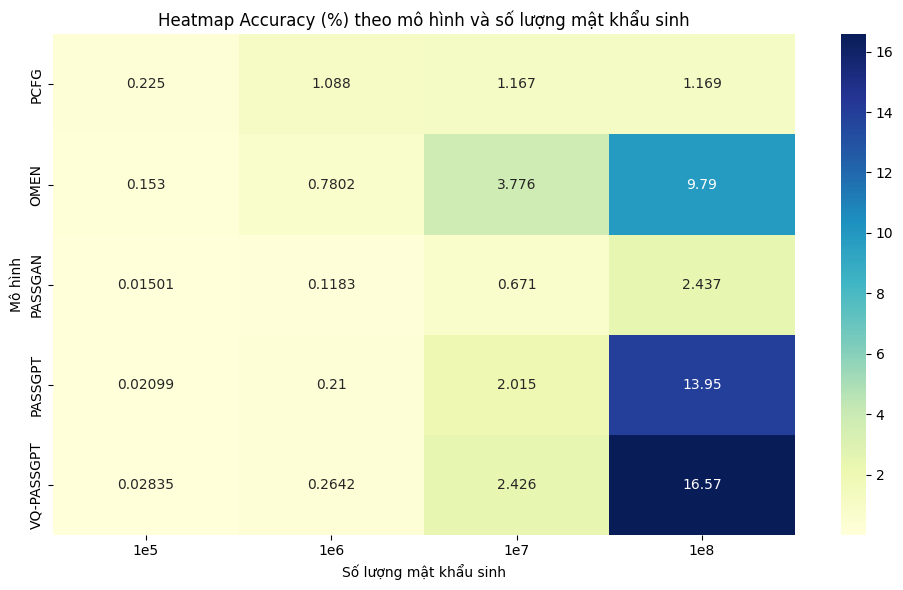

In [9]:
# Tạo biểu đồ heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(accuracy_df.astype(float), annot=True, fmt=".4g", cmap="YlGnBu", cbar=True)

# Thêm tiêu đề và nhãn
plt.title("Heatmap Accuracy (%) theo mô hình và số lượng mật khẩu sinh")
plt.xlabel("Số lượng mật khẩu sinh")
plt.ylabel("Mô hình")

# Hiển thị heatmap
plt.tight_layout()
plt.show()

In [10]:
combinations = {
    'M1': ['VQ-PASSGPT', 'PASSGPT'],
    'M2': ['VQ-PASSGPT', 'PASSGPT', 'PASSGAN'],
    'M3': ['VQ-PASSGPT', 'PASSGPT', 'PASSGAN', 'OMEN'],
    'M4': ['VQ-PASSGPT', 'PASSGPT', 'PASSGAN', 'OMEN', 'PCFG'],
}
file_map = {
    'VQ-PASSGPT': 'passgptv2',
    'PASSGPT': 'passgpt',
    'PASSGAN': 'passgan',
    'OMEN': 'omen',
    'PCFG': 'pcfg'
}


In [11]:
# Bước 1: Đọc các mật khẩu đoán đúng của từng model
model_correct_predictions = {}

for model, prefix in file_map.items():
    model_correct_predictions[model] = {}
    for size in sizes:
        correct_set = set()
        filename = f"{prefix}_GEN/{prefix}_gen_{size}.txt"
        try:
            with open(filename, 'r', encoding='latin-1', errors='ignore') as f:
                for line in f:
                    pwd = line.strip()
                    if pwd in test_data_set:
                        correct_set.add(pwd)
        except FileNotFoundError:
            print(f"⚠️ File not found: {filename}")
        model_correct_predictions[model][size] = correct_set


In [12]:
combine_accuracies = {}

for combo_name, model_list in combinations.items():
    combine_accuracies[combo_name] = {}
    for size in sizes:
        combined_correct = set()
        for model in model_list:
            combined_correct |= model_correct_predictions[model][size]  # hợp các mật khẩu đúng
        acc = (len(combined_correct) / len(test_data_set)) * 100 if test_data else 0
        combine_accuracies[combo_name][size] = acc


In [13]:
combine_df = pd.DataFrame(combine_accuracies).T
combine_df = combine_df[sizes]
print("\n📊 Bảng độ chính xác (Accuracy %) của các mô hình kết hợp:\n")
combine_df.round(4)



📊 Bảng độ chính xác (Accuracy %) của các mô hình kết hợp:



,1e5,1e6,1e7,1e8
M1,0.0499,0.4772,4.2700,22.5767
M2,0.0651,0.5940,4.8234,23.2694
M3,0.2186,1.3484,7.6745,25.9339
M4,0.4228,2.2991,8.4128,26.3014


Đang xử lý passgan_GEN/passgan_gen_1e5.txt
Đang xử lý passgan_GEN/passgan_gen_1e6.txt
Đang xử lý passgan_GEN/passgan_gen_1e7.txt
Đang xử lý passgan_GEN/passgan_gen_1e8.txt
Đang xử lý passgpt_GEN/passgpt_gen_1e5.txt
Đang xử lý passgpt_GEN/passgpt_gen_1e6.txt
Đang xử lý passgpt_GEN/passgpt_gen_1e7.txt
Đang xử lý passgpt_GEN/passgpt_gen_1e8.txt
Đang xử lý passgptv2_GEN/passgptv2_gen_1e5.txt
Đang xử lý passgptv2_GEN/passgptv2_gen_1e6.txt
Đang xử lý passgptv2_GEN/passgptv2_gen_1e7.txt
Đang xử lý passgptv2_GEN/passgptv2_gen_1e8.txt


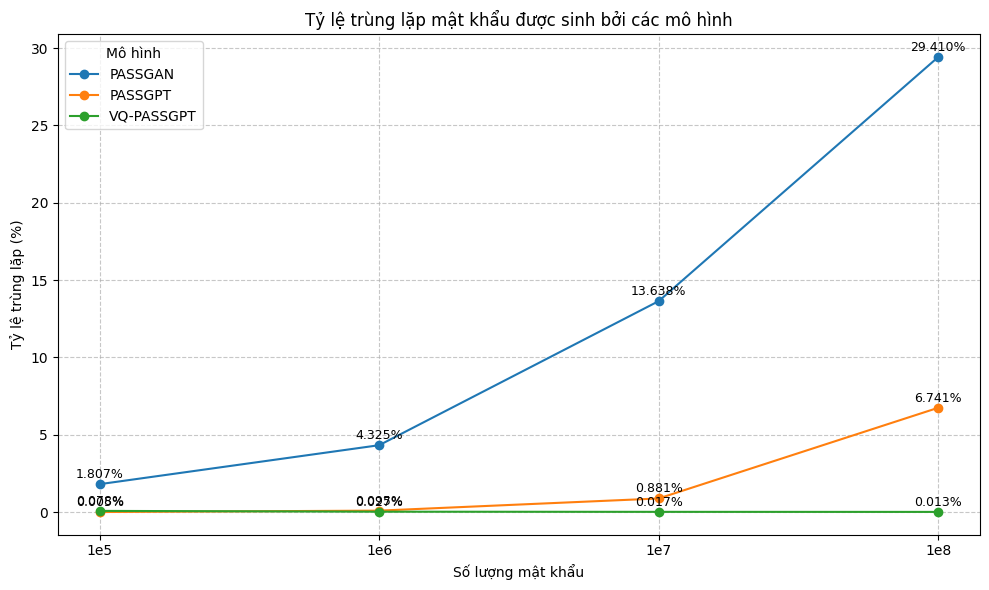

In [17]:
generators = ['passgan', 'passgpt', 'passgptv2']
sizes = ['1e5', '1e6', '1e7', '1e8']

# Map size string -> số lượng dòng mong muốn mặc định
size_to_count = {
    '1e5': 10**5,
    '1e6': 10**6,
    '1e7': 10**7,
    '1e8': 10**8
}

# Ghi đè riêng cho PCFG-1e8
custom_expected_lines = {
    ('pcfg', '1e8'): 22_000_000
}

duplication_rates = {}

for gen in generators:
    if gen == 'passgptv2':
        duplication_rates['VQ-PASSGPT'] = {}
    else:
        duplication_rates[gen.upper()] = {}
    for size in sizes:
        # Xác định số dòng kỳ vọng (custom nếu có)
        expected_total = custom_expected_lines.get((gen, size), size_to_count[size])
        file_path = f'{gen}_GEN/{gen}_gen_{size}.txt'
        print(f'Đang xử lý {file_path}')
        
        with open(file_path, 'r', encoding='latin-1', errors='ignore') as f:
            unique_passwords = set(line.strip() for line in f)

        duplicated = expected_total - len(unique_passwords)
        duplication_rate = (duplicated / expected_total) * 100 if expected_total else 0
        if gen == 'passgptv2':
            duplication_rates['VQ-PASSGPT'][size] = duplication_rate
        else:
            duplication_rates[gen.upper()][size] = duplication_rate

# Create DataFrame for plotting
dup_df = pd.DataFrame(duplication_rates).T
dup_df = dup_df[sizes]  # ensure consistent column order

# Plotting
plt.figure(figsize=(10, 6))

for model in dup_df.index:
    y_values = dup_df.loc[model]
    plt.plot(sizes, y_values, marker='o', label=model)
    
    # Annotate each point with the percentage
    for x, y in zip(sizes, y_values):
        plt.text(x, y + 0.2, f'{y:.3f}%', ha='center', va='bottom', fontsize=9)

plt.title("Tỷ lệ trùng lặp mật khẩu được sinh bởi các mô hình")
plt.xlabel("Số lượng mật khẩu")
plt.ylabel("Tỷ lệ trùng lặp (%)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title="Mô hình")
plt.tight_layout()
plt.show()

In [18]:
def split_dataset(file_path, test_ratio=0.4):
    with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
        lines = [line.strip() for line in f if line.strip()]
    
    split_index = int(len(lines) * (1 - test_ratio))
    return lines[:split_index], lines[split_index:]

In [ ]:
def evaluate_generators(base_dir='./'):
    countries = ['China', 'Indonesia', 'Malaysia','VietNam']
    sizes = ['1e5', '1e6', '1e7', '1e8']
    accuracies = {}

    for country in countries:
        print(f"\n>>> Đang xử lý quốc gia: {country}")
        dataset_path = os.path.join(base_dir, country, f"{country.lower()}_Dataset.txt")
        _, test_data = split_dataset(dataset_path)
        test_data_set = set(test_data)

        accuracies[country.upper()] = {}
        for size in sizes:
            gen_file = os.path.join(base_dir, country, f"{country.lower()}_gen_{size}.txt")
            print(f"==> Đang kiểm tra {gen_file}")
            match_count = 0

            with open(gen_file, 'r', encoding='latin-1', errors='ignore') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) < 2:
                        continue
                    password = parts[1] 
                    if password in test_data_set:
                        match_count += 1
            accuracy = (match_count / len(test_data)) * 100 if test_data else 0
            accuracies[country.upper()][size] = round(accuracy, 4)

    return accuracies

In [ ]:
acc = evaluate_generators('./')
df = pd.DataFrame.from_dict(acc, orient='index')
df


>>> Đang xử lý quốc gia: China
==> Đang kiểm tra ./China\china_gen_1e5.txt
==> Đang kiểm tra ./China\china_gen_1e6.txt
==> Đang kiểm tra ./China\china_gen_1e7.txt
==> Đang kiểm tra ./China\china_gen_1e8.txt

>>> Đang xử lý quốc gia: Indonesia
==> Đang kiểm tra ./Indonesia\indonesia_gen_1e5.txt
==> Đang kiểm tra ./Indonesia\indonesia_gen_1e6.txt
==> Đang kiểm tra ./Indonesia\indonesia_gen_1e7.txt
==> Đang kiểm tra ./Indonesia\indonesia_gen_1e8.txt

>>> Đang xử lý quốc gia: Malaysia
==> Đang kiểm tra ./Malaysia\malaysia_gen_1e5.txt
==> Đang kiểm tra ./Malaysia\malaysia_gen_1e6.txt
==> Đang kiểm tra ./Malaysia\malaysia_gen_1e7.txt
==> Đang kiểm tra ./Malaysia\malaysia_gen_1e8.txt

>>> Đang xử lý quốc gia: VietNam
==> Đang kiểm tra ./VietNam\vietnam_gen_1e5.txt
==> Đang kiểm tra ./VietNam\vietnam_gen_1e6.txt
==> Đang kiểm tra ./VietNam\vietnam_gen_1e7.txt
==> Đang kiểm tra ./VietNam\vietnam_gen_1e8.txt


,1e5,1e6,1e7,1e8
CHINA,0.4756,4.3895,24.1390,47.9188
INDONESIA,0.4446,3.9413,19.4570,41.0161
MALAYSIA,0.7012,4.9664,15.9427,30.3348
VIETNAM,1.5125,10.5714,29.2447,47.1346


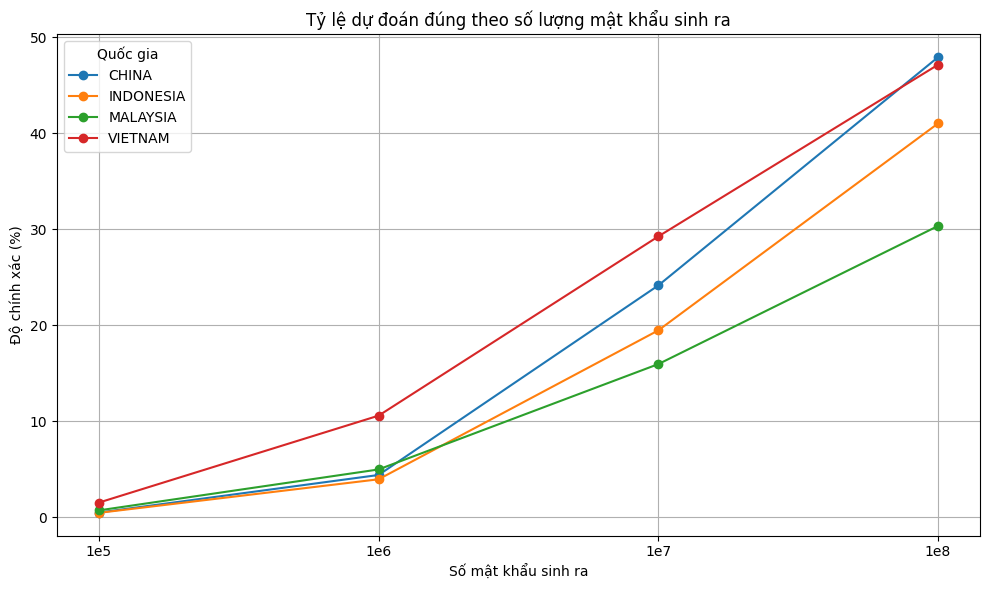

In [ ]:
plt.figure(figsize=(10, 6))
for country in df.index:
    plt.plot(df.columns, df.loc[country], marker='o', label=country)

plt.title("Tỷ lệ dự đoán đúng theo số lượng mật khẩu sinh ra")
plt.xlabel("Số mật khẩu sinh ra")
plt.ylabel("Độ chính xác (%)")
plt.legend(title="Quốc gia")
plt.grid(True)
plt.tight_layout()
plt.show()

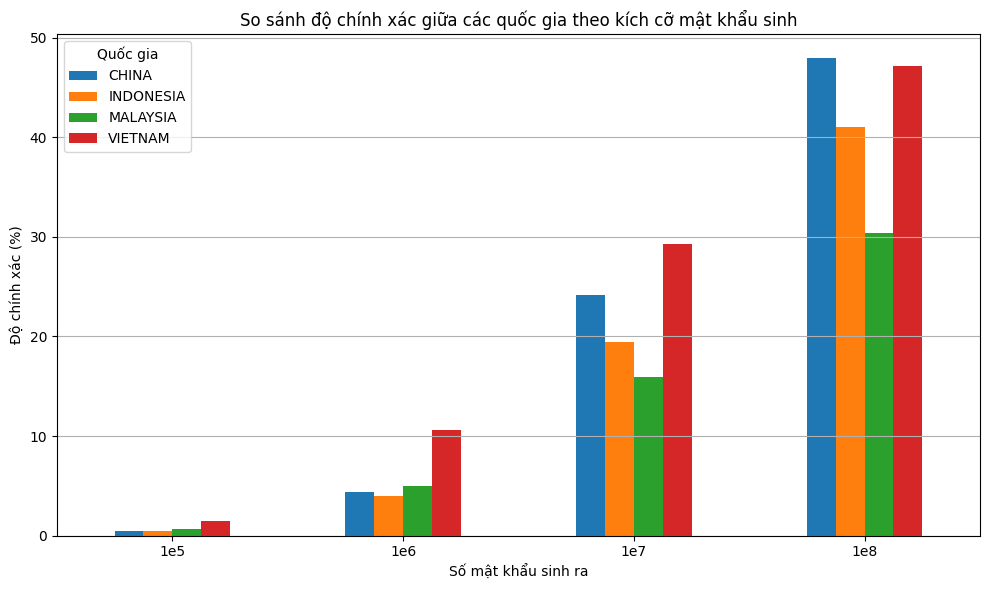

In [ ]:
df.T.plot(kind='bar', figsize=(10, 6))
plt.title("So sánh độ chính xác giữa các quốc gia theo kích cỡ mật khẩu sinh")
plt.xlabel("Số mật khẩu sinh ra")
plt.ylabel("Độ chính xác (%)")
plt.legend(title="Quốc gia")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

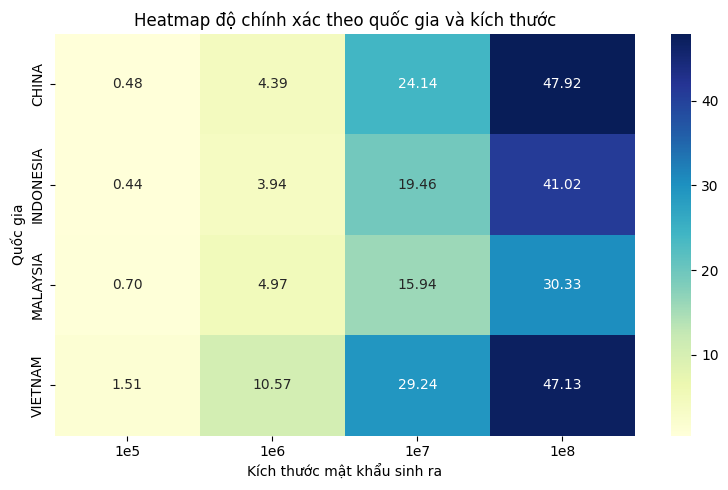

In [ ]:

plt.figure(figsize=(8, 5))
sns.heatmap(df, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Heatmap độ chính xác theo quốc gia và kích thước")
plt.xlabel("Kích thước mật khẩu sinh ra")
plt.ylabel("Quốc gia")
plt.tight_layout()
plt.show()

In [ ]:
def read_passwords(path):
    with open(path, 'r', encoding='latin-1', errors='ignore') as f:
        return [line.strip() for line in f if line.strip()]

def guessfuse_eval(file_list, k=10000, validation_lines=None):
    guess_lists = [read_passwords(f) for f in file_list]
    l = len(guess_lists)

    subsets = defaultdict(list)
    seen = {}
    for rank in range(max(len(g) for g in guess_lists)):
        for i, g_list in enumerate(guess_lists):
            if rank < len(g_list):
                pwd = g_list[rank]
                bitmask = seen.get(pwd, 0)
                bitmask |= (1 << i)
                seen[pwd] = bitmask
    for pwd, bitmask in seen.items():
        key = format(bitmask, f'0{l}b')
        subsets[key].append(pwd)

    def power_intervals(n):
        result = []
        base, tol, temp = 10, 1, 0
        while temp < n:
            if temp < base:
                result.append((temp, temp + tol))
                temp += tol
            else:
                tol = base
                result.append((temp, temp + tol))
                temp += tol
                base *= 10
        return result

    all_segments = []
    for label, pw_list in subsets.items():
        for start, end in power_intervals(len(pw_list)):
            segment = pw_list[start:end]
            if segment:
                hit = sum(1 for pw in segment if pw in validation_lines)
                rate = hit / len(segment)
                all_segments.append((rate, segment))

    all_segments.sort(reverse=True, key=lambda x: x[0])
    final_list = []
    for _, segment in all_segments:
        for pw in segment:
            if len(final_list) >= k:
                break
            if pw not in final_list:
                final_list.append(pw)
        if len(final_list) >= k:
            break

    return final_list

# Đường dẫn tổ hợp mô hình
file_paths = {
    'PASSGPTV2': ['passgptv2_GEN/passgptv2_gen_1e7.txt'],
    'PASSGPTV2+PASSGPT': [
        'passgptv2_GEN/passgptv2_gen_1e7.txt',
        'passgpt_GEN/passgpt_gen_1e7.txt'
    ],
    'PASSGPTV2+PASSGPT+PASSGAN': [
        'passgptv2_GEN/passgptv2_gen_1e7.txt',
        'passgpt_GEN/passgpt_gen_1e7.txt',
        'passgan_GEN/passgan_gen_1e7.txt'
    ],
    'PASSGPTV2+PASSGPT+PASSGAN+OMEN': [
        'passgptv2_GEN/passgptv2_gen_1e7.txt',
        'passgpt_GEN/passgpt_gen_1e7.txt',
        'passgan_GEN/passgan_gen_1e7.txt',
        'omen_GEN/omen_gen_1e7.txt'
    ],
    'PASSGPTV2+PASSGPT+PASSGAN+OMEN+PCFG': [
        'passgptv2_GEN/passgptv2_gen_1e7.txt',
        'passgpt_GEN/passgpt_gen_1e7.txt',
        'passgan_GEN/passgan_gen_1e7.txt',
        'omen_GEN/omen_gen_1e7.txt',
        'pcfg_GEN/pcfg_gen_1e7.txt'

    ]
}

# Chạy đánh giá
results = {}
for label, paths in file_paths.items():
    fused_passwords = guessfuse_eval(paths, k=10000, validation_lines=test_data_set)
    matched = sum(1 for pw in fused_passwords if pw in test_data_set)
    acc = matched / len(test_data_set) * 100
    results[label] = round(acc, 4)

# In kết quả
df = pd.DataFrame.from_dict(results, orient='index', columns=['Accuracy (%)'])
df 

,Accuracy (%)
PASSGPTV2,0.0075
PASSGPTV2+PASSGPT,0.0141
PASSGPTV2+PASSGPT+PASSGAN,0.0164
PASSGPTV2+PASSGPT+PASSGAN+OMEN,0.0269
PASSGPTV2+PASSGPT+PASSGAN+OMEN+PCFG,0.0347
